# Project 1 - Generalized Linear Models with Gradient Descent

## Yan Bo Zeng

In [2]:
library(dplyr)
library(repr)
options(repr.plot.width = 12, repr.plot.height = 10)
options(scipen = 999)

# 1. Ordinary Least Squares

Recall the ordinary least squares model $y_i = x_i'\beta + \epsilon_i$. The maximum likelihood estimator (MLE) for the coefficient parameter $\beta$ is
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} -\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 \\
    & = \arg\min_{\beta \in \mathbb{R}^k} \frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2
\end{align*}

Denote $\frac{1}{2n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)^2 = Q(\beta)$, $X$ as the model matrix including the intercept term, and $Y$ as the outcome vector. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - x_i'\beta \right)x_i \\
    & = \frac{1}{n} X'\left(Y - X\beta \right)
\end{align*}

Thus, given a learning rate $\alpha_t$, gradient descent will iterate on
\begin{align*}
    \hat{\beta}_{t+1} & = \hat{\beta}_{t} + \alpha_t \nabla Q(\hat{\beta}_{t}) \\
    & = \hat{\beta}_{t} + \alpha_t \frac{1}{n} X'\left(Y - X\hat{\beta}_{t} \right)
\end{align*}

In [3]:
#Define the cost and gradient functions for OLS.
OLS_cost <- function(X, y, beta) {
    return(mean((y - X %*% beta)^2) / 2)
}

OLS_gradient <- function(X, y, beta) {
    return(t(X) %*% (y - X %*% beta) / length(y))
}

In [4]:
#Define the gradient descent function.
gradient_descent <- function(X, y, beta_init = rep(0, ncol(X)), alpha = 0.01, num_iters = 10^4,
                             error_func = OLS_cost, grad_func = OLS_gradient, history_var = "log(price)",
                             linesearch = FALSE, linesearch_c = 0.1) {
    
    #Record beta for one of the coefficients and errors (cost values) from each iteration.
    beta_history <- rep(0, num_iters)
    error_history <- rep(0, num_iters)
    
    #Initialize beta.
    beta <- beta_init
    
    #Record alpha for line search.
    alpha_init <- alpha
    
    #Implement gradient descent.
    for (i in 1:num_iters) {
        error_old <- error_func(X, y, beta)
        delta <- grad_func(X, y, beta)
        beta <- beta + alpha * delta
        
        #Implement backtracking line search.
        if (linesearch == TRUE) {
            while (error_func(X, y, beta) > (error_old - linesearch_c*alpha*(norm(delta)^2))) {
                error_old <- error_func(X, y, beta)
                alpha = alpha / 2
                delta <- grad_func(X, y, beta)
                beta <- beta + alpha * delta
            }
            alpha <- alpha_init
        }
        
        error_history[i] <- error_func(X, y, beta)
        beta_history[i] <- beta[history_var, 1]
    }
    
    #Return the history for plotting.
    return(list(beta, error_history, beta_history))
}

## Test the algorithm on orange juice advertisement data.
Firstly, we use the R built-in glm() package to obtain the coefficient estimates.

In [5]:
oj <- read.csv("C:/Users/yanbo/OneDrive/Stanford MS&E 311 Optimization/oj.csv")
X <- model.matrix(log(sales) ~ log(price) + brand, data = oj)
y <- log(oj$sales)

builtin <- glm(formula = log(sales) ~ log(price) + brand, data = oj)
coef(builtin) %>% as.matrix()

(Intercept),10.8288216
log(price),-3.1386914
brandminute.maid,0.8701747
brandtropicana,1.5299428


Then, we can try different learning rates and use line search to help us find a good one.

In [6]:
betalist001 <- gradient_descent(X, y)
betalist01 <- gradient_descent(X, y, alpha = 0.1)
betalist04 <- gradient_descent(X, y, alpha = 0.4)
betalist2 <- gradient_descent(X, y, alpha = 2)
betalist_ls <- gradient_descent(X, y, alpha = 2, linesearch = TRUE)
cbind(betalist001[[1]], betalist01[[1]], betalist04[[1]], betalist2[[1]], betalist_ls[[1]])

(Intercept),10.599653,10.8288216,10.8288216,NaN,10.8288216
log(price),-2.677485,-3.1386914,-3.1386914,NaN,-3.1386914
brandminute.maid,0.723648,0.8701747,0.8701747,NaN,0.8701747
brandtropicana,1.261710,1.5299428,1.5299428,NaN,1.5299428


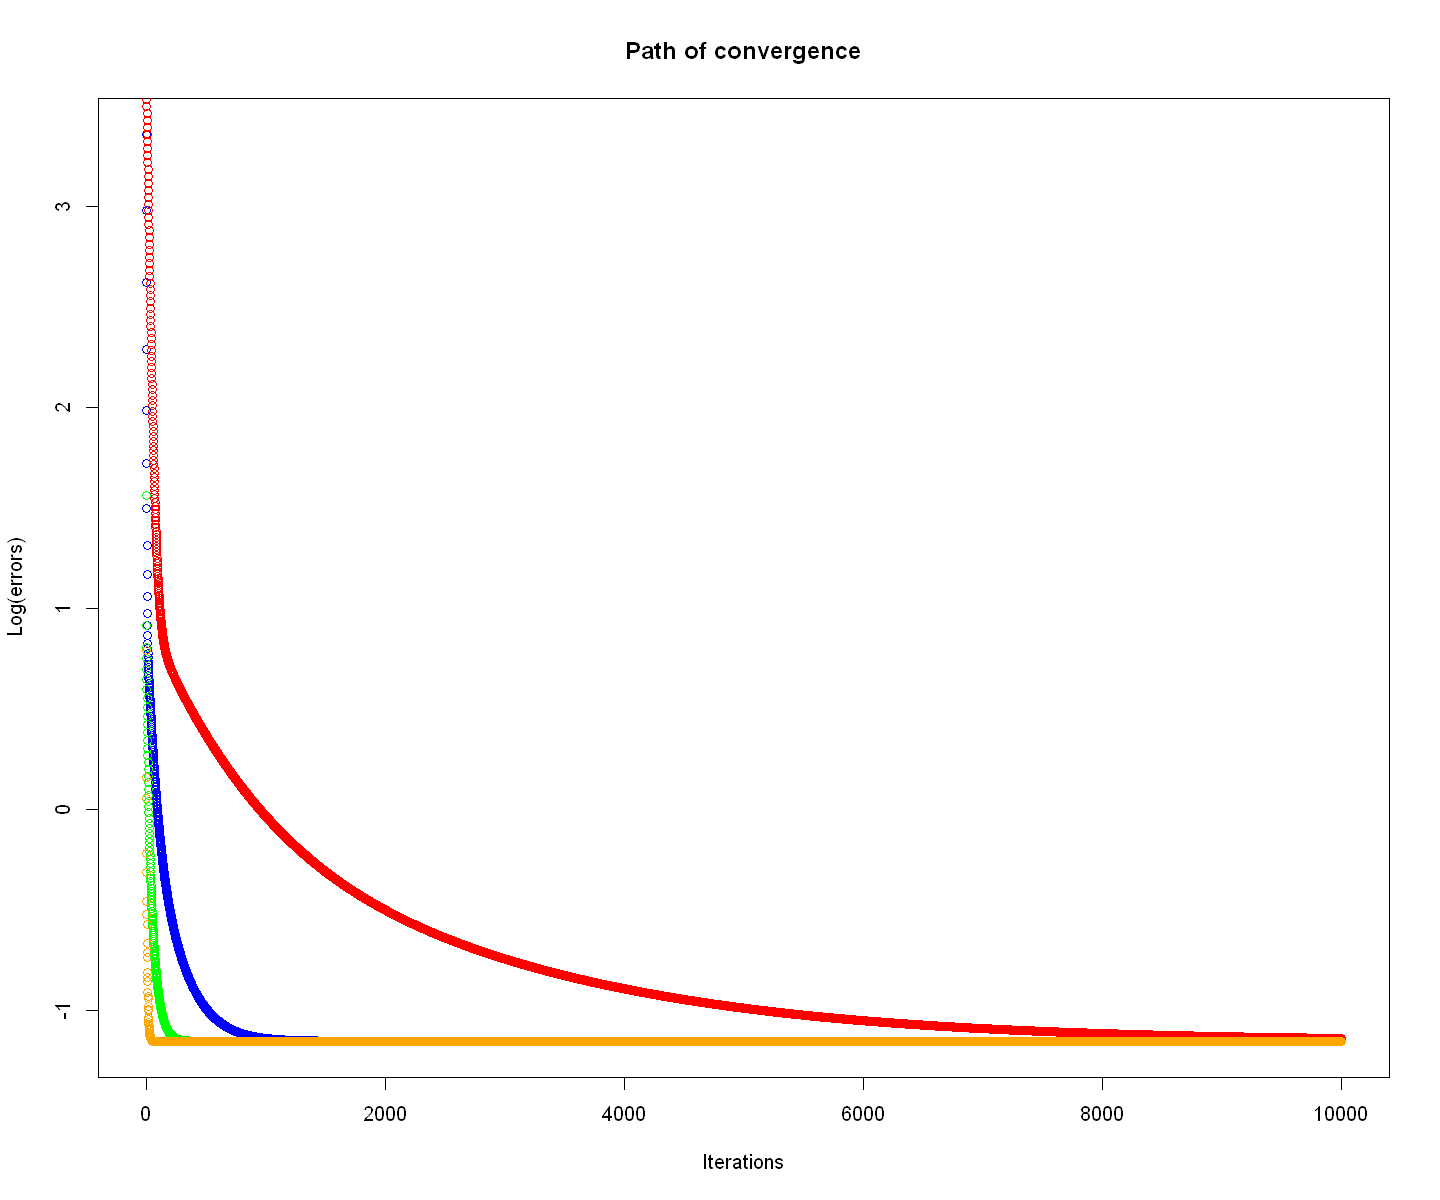

In [7]:
#Visualize the path of convergence.
plot(log(betalist01[[2]]), col = 'blue', main = 'Path of convergence', ylab = 'Log(errors)', xlab = 'Iterations')
points(log(betalist001[[2]]), col = 'red')
points(log(betalist04[[2]]), col = 'green')
points(log(betalist_ls[[2]]), col = 'orange')

Line search is really helpful in preventing the algo from blowing up and finding a decent learning rate.

Learning rate of 2 blows up, returning NAs for all coefficients.

# 2. Logistic and Probit Regressions

Recall that in logit and probit models, $\hat{\beta}$ is obtained by maximizing the log-likelihood function or equivalently minimizing the cross-entropy loss function.
\begin{align*}
    \hat{\beta} & = \arg\max_{\beta \in \mathbb{R}^k} \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\log{\left( \prod_{i=1}^{n} F(x_i'\beta)^{y_i} \left(1 - F(x_i'\beta) \right)^{1-y_i} \right)} \\
    & = \arg\min_{\beta \in \mathbb{R}^k} -\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right)
\end{align*}

Denote $-\frac{1}{n} \sum_{i=1}^{n} \left(y_i\log{F(x_i'\beta)} + (1-y_i)\log{\left(1 - F(x_i'\beta) \right)} \right) = Q(\beta)$. Then, the gradient is
\begin{align*}
    \nabla Q(\beta) & = \frac{\partial}{\partial\beta} Q(\beta) \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i}{F(x_i'\beta)} - \frac{1-y_i}{1-F(x_i'\beta)} \right) f(x_i'\beta)x_i \\
    & = -\frac{1}{n} \sum_{i=1}^{n} \frac{y_i-F(x_i'\beta)}{F(x_i'\beta) \left(1-F(x_i'\beta)\right)} f(x_i'\beta)x_i
\end{align*}

For logit, $F(x_i'\beta) = \frac{\exp{x_i'\beta}}{1+\exp{x_i'\beta}}$.

For probit, $F(x_i'\beta) = \Phi(x_i'\beta)$, and $f(x_i'\beta) = \phi(x_i'\beta)$, where $\Phi(\cdot)$ and $\phi(\cdot)$ are the standard normal CDF and PDF, respectively.

In [ ]:
#Define the cost and gradient functions for logit.
logit_cost <- function(X, y, beta) {
    return(mean((y - X %*% beta)^2) / 2)
}

logit_gradient <- function(X, y, beta) {
    return(t(X) %*% (y - X %*% beta) / length(y))
}

In [ ]:
#Sigmoid function for logistic regression
sigmoid <- function(z)
{
  g <- 1/(1+exp(-z))
  return(g)
}

#Loss Function for gradient descent (logistic regression)
cost <- function(beta)
{
  m <- nrow(X)
  g <- sigmoid(X%*%beta)
  J <- (1/m)*sum((-Y*log(g)) - ((1-Y)*log(1-g)))
  return(J)
}

In [ ]:
mroz <- read.csv("C:/Users/yanbo/OneDrive/Stanford ECON 271 Intermediate Econometrics II/Problem Sets/mroz.csv")
x <- model.matrix(part ~ kidslt6 + age + educ + nwifeinc, data = mroz)
y <- mroz$part
n <- length(y)

log_likelihood <- function(y, x, beta) {
  return(-sum(y*log(pnorm(x%*%beta)) + (1-y)*log(1-pnorm(x%*%beta))))
}

gradient <- function(y, x, beta) {
  scalar <- y*(dnorm(x%*%beta)/pnorm(x%*%beta)) - (1-y)*(dnorm(x%*%beta)/(1-pnorm(x%*%beta)))
  s <- rep(0, 5)
  for (i in 1:n) {
    s <- s + (scalar[i]*x[i, ])
  }
  return(-s/n)
}

#With the help of analytical gradient.
answer <- optim(par = rep(0, 5), fn = log_likelihood, gr = gradient, y = y, x = x, method = "BFGS")
beta_hat <- answer$par
names(beta_hat) <- colnames(x)
beta_hat

#Without the help of analytical gradient -- Seems better here.
answer <- optim(par = rep(0, 5), fn = log_likelihood, y = y, x = x, method = "BFGS")
beta_hat <- answer$par
names(beta_hat) <- colnames(x)
beta_hat

#glm() for checking.
myprobit <- glm(part ~ kidslt6 + age + educ + nwifeinc, family = binomial(link = "probit"), data = mroz)
summary(myprobit)